# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Fall 2021

## Setup

You shouldn't have to change anything in these cells

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [3]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

In [4]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_standard.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        
        print(type(data))
        print(data.shape)
        
        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
        break
    break
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])


In [ ]:
# net = models.NetA().to(device)
# net.load_state_dict(torch.load("netA_standard.pt"))
# net

**Visualize some perturbed samples**

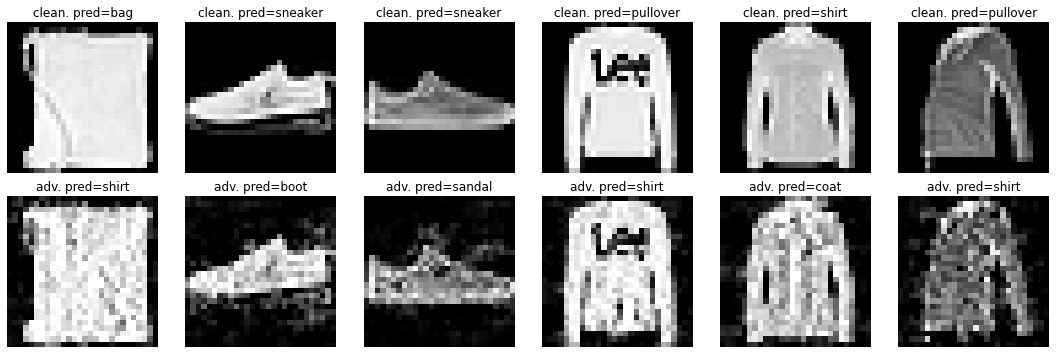

In [43]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        #EPS = 0
        #EPS = 0.1
        #EPS = 0.2
        #EPS = 0.3
        
        #EPS = 0
        #EPS = 1.0
        #EPS = 2.0
        #EPS = 3.0
        EPS = 4.0
        
        ITS = 10
        ALP = 1.85*(EPS/ITS)
        
        #adv_data = attacks.FGSM_attack(net,device,data.clone().detach(),labels,eps=EPS)
        #adv_data = attacks.PGD_attack(net,device,data.clone().detach(),labels,eps=EPS,alpha=ALP,iters=ITS,rand_start=True)
        adv_data = attacks.FGM_L2_attack(net,device,data.clone().detach(),labels,eps=EPS)
        ###
        
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()
        break

## Test Attacks - Whitebox & Blackbox

Don't forget to plot accuracy vs. epsilon curves!

In [24]:
eps_values = np.linspace(0, 0.1, 11)

random_whitebox_acc = []
random_blackbox_acc = []

fgsm_whitebox_acc = []
fgsm_blackbox_acc = []

pgd_whitebox_acc = []
pgd_blackbox_acc = []

print(eps_values)
print(len(eps_values))

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
11


In [59]:
## Load pretrained models
whitebox = models.NetA()
blackbox = models.NetB()

whitebox.load_state_dict(torch.load("netA_standard.pt"))
blackbox.load_state_dict(torch.load("netB_standard.pt"))

whitebox = whitebox.to(device); blackbox = blackbox.to(device) 
whitebox.eval(); blackbox.eval()

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)
test_acc,_ = test_model(blackbox,test_loader,device)
print("Initial Accuracy of Blackbox Model: ",test_acc)

## Test the models against an adversarial attack

# TODO: Set attack parameters here
#ATK_EPS = eps_values[0]
#ATK_EPS = eps_values[1]
#ATK_EPS = eps_values[2]
#ATK_EPS = eps_values[3]
#ATK_EPS = eps_values[4]
#ATK_EPS = eps_values[5]
#ATK_EPS = eps_values[6]
#ATK_EPS = eps_values[7]
#ATK_EPS = eps_values[8]
#ATK_EPS = eps_values[9]
ATK_EPS = eps_values[10]

ATK_ITERS = 10
ATK_ALPHA = 1.85 * (ATK_EPS / ATK_ITERS)

whitebox_correct = 0.
blackbox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    # TODO: Perform adversarial attack here
    #adv_data = attacks.random_noise_attack(whitebox, device, data.clone().detach(), eps=ATK_EPS)
    
    #adv_data = attacks.FGSM_attack(whitebox,device,data.clone().detach(),labels,eps=ATK_EPS)
    
    adv_data = attacks.PGD_attack(whitebox,device,data.clone().detach(),labels,eps=ATK_EPS,
    alpha=ATK_ALPHA,iters=ATK_ITERS,rand_start=True)

    # Sanity checking if adversarial example is "legal"
    assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
    assert(adv_data.max() == 1.)
    assert(adv_data.min() == 0.)
    
    # Compute accuracy on perturbed data
    with torch.no_grad():
        # Stat keeping - whitebox
        whitebox_outputs = whitebox(adv_data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        # Stat keeping - blackbox
        blackbox_outputs = blackbox(adv_data)
        _,blackbox_preds = blackbox_outputs.max(1)
        blackbox_correct += blackbox_preds.eq(labels).sum().item()
        running_total += labels.size(0)
    
#     # Plot some samples
#     if batch_idx == 1:
#         plt.figure(figsize=(15,5))
#         for jj in range(12):
#             plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
#         plt.tight_layout()
#         plt.show()

# Print final 
whitebox_acc = whitebox_correct/running_total
blackbox_acc = blackbox_correct/running_total

# random_whitebox_acc.append(whitebox_acc)
# random_blackbox_acc.append(blackbox_acc)

# fgsm_whitebox_acc.append(whitebox_acc)
# fgsm_blackbox_acc.append(blackbox_acc)

pgd_whitebox_acc.append(whitebox_acc)
pgd_blackbox_acc.append(blackbox_acc)

print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

print("Done!")

Initial Accuracy of Whitebox Model:  0.9251
Initial Accuracy of Blackbox Model:  0.9208
Attack Epsilon: 0.1; Whitebox Accuracy: 0.005; Blackbox Accuracy: 0.3308
Done!


In [60]:
print(len(random_whitebox_acc))
print(random_whitebox_acc)
print(len(random_blackbox_acc))
print(random_blackbox_acc)
print(len(fgsm_whitebox_acc))
print(fgsm_whitebox_acc)
print(len(fgsm_blackbox_acc))
print(fgsm_blackbox_acc)
print(len(pgd_whitebox_acc))
print(pgd_whitebox_acc)
print(len(pgd_blackbox_acc))
print(pgd_blackbox_acc)

11
[0.9251, 0.9245, 0.9243, 0.9227, 0.9215, 0.9194, 0.916, 0.9139, 0.9074, 0.9055, 0.8968]
11
[0.9208, 0.9204, 0.9214, 0.9158, 0.9089, 0.9042, 0.8952, 0.8857, 0.8748, 0.852, 0.8461]
11
[0.9251, 0.7072, 0.5823, 0.5129, 0.4545, 0.4068, 0.3672, 0.3347, 0.3091, 0.2899, 0.2768]
11
[0.9208, 0.8757, 0.8214, 0.7651, 0.7016, 0.6481, 0.6031, 0.5668, 0.5369, 0.5077, 0.4815]
11
[0.9251, 0.6581, 0.4131, 0.265, 0.1675, 0.1032, 0.0624, 0.0345, 0.0175, 0.0095, 0.005]
11
[0.9208, 0.8729, 0.806, 0.7274, 0.6358, 0.5547, 0.4925, 0.4415, 0.4024, 0.3674, 0.3308]


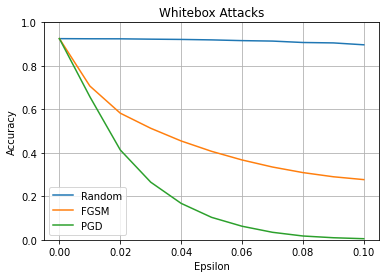

In [61]:
figure, axis = plt.subplots()

axis.plot(eps_values, random_whitebox_acc, label = "Random")
axis.plot(eps_values, fgsm_whitebox_acc, label = "FGSM")
axis.plot(eps_values, pgd_whitebox_acc, label = "PGD")

axis.set(xlabel = "Epsilon", ylabel = "Accuracy", title = "Whitebox Attacks")
axis.grid()
#plt.yscale("log")
plt.ylim([0, 1])
plt.legend()
plt.show()

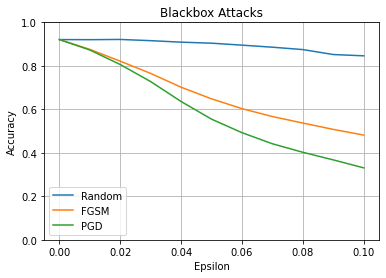

In [62]:
figure, axis = plt.subplots()

axis.plot(eps_values, random_blackbox_acc, label = "Random")
axis.plot(eps_values, fgsm_blackbox_acc, label = "FGSM")
axis.plot(eps_values, pgd_blackbox_acc, label = "PGD")

axis.set(xlabel = "Epsilon", ylabel = "Accuracy", title = "Blackbox Attacks")
axis.grid()
#plt.yscale("log")
plt.ylim([0, 1])
plt.legend()
plt.show()

## Model Training for Lab 3

In [14]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
#model_checkpoint = "netA_standard.pt"
#model_checkpoint = "netB_standard.pt"

#model_checkpoint = "netA_advtrain_fgsm0p1.pt"
#model_checkpoint = "netA_advtrain_pgd0p1.pt"

# ATK_EPS = 0.1

#model_checkpoint = "netA_advtrain_pgd0p01.pt"
#model_checkpoint = "netA_advtrain_pgd0p05.pt"
#model_checkpoint = "netA_advtrain_pgd0p15.pt"
#model_checkpoint = "netA_advtrain_pgd0p2.pt"
#model_checkpoint = "netA_advtrain_pgd0p3.pt"
model_checkpoint = "netA_advtrain_pgd0p5.pt"

#ATK_EPS = 0.01
#ATK_EPS = 0.05
#ATK_EPS = 0.15
#ATK_EPS = 0.2
#ATK_EPS = 0.3
ATK_EPS = 0.5


## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)
        
        ###########################################################################################
        # Adversarial Training
        #adv_data = attacks.FGSM_attack(net,device,data.clone().detach(),labels,eps = 0.1)
        
        adv_data = attacks.PGD_attack(net,device,data.clone().detach(),labels,eps = ATK_EPS,
                                      alpha = 1.85 * (ATK_EPS / 4),iters = 4,rand_start=True)
        ###########################################################################################
        
        # Forward pass
        #################################
        # Adversarial Training
        outputs = net(adv_data)
        #outputs = net(data)
        #################################
        
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)
        
    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model    
    torch.save(net.state_dict(), model_checkpoint)
    
    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.09868; TrainLoss: 2.30338; TestAcc: 0.10000; TestLoss: 2.30282
Epoch: [ 1 / 20 ]; TrainAcc: 0.10007; TrainLoss: 2.30290; TestAcc: 0.10000; TestLoss: 2.30265
Epoch: [ 2 / 20 ]; TrainAcc: 0.09802; TrainLoss: 2.30288; TestAcc: 0.10000; TestLoss: 2.30281
Epoch: [ 3 / 20 ]; TrainAcc: 0.09897; TrainLoss: 2.30285; TestAcc: 0.10000; TestLoss: 2.30266
Epoch: [ 4 / 20 ]; TrainAcc: 0.09958; TrainLoss: 2.30285; TestAcc: 0.10000; TestLoss: 2.30275
Epoch: [ 5 / 20 ]; TrainAcc: 0.09855; TrainLoss: 2.30291; TestAcc: 0.10000; TestLoss: 2.30270
Epoch: [ 6 / 20 ]; TrainAcc: 0.09872; TrainLoss: 2.30284; TestAcc: 0.10000; TestLoss: 2.30262
Epoch: [ 7 / 20 ]; TrainAcc: 0.09998; TrainLoss: 2.30286; TestAcc: 0.10000; TestLoss: 2.30263
Epoch: [ 8 / 20 ]; TrainAcc: 0.10068; TrainLoss: 2.30280; TestAcc: 0.10000; TestLoss: 2.30291
Epoch: [ 9 / 20 ]; TrainAcc: 0.09998; TrainLoss: 2.30285; TestAcc: 0.10000; TestLoss: 2.30307
Epoch: [ 10 / 20 ]; TrainAcc: 0.09785; TrainLoss: 2.30286; T

In [15]:
## Load pretrained models
fgsm_net = models.NetA()
pgd_net = models.NetA()

fgsm_net.load_state_dict(torch.load("netA_advtrain_fgsm0p1.pt"))

#pgd_net.load_state_dict(torch.load("netA_advtrain_pgd0p1.pt"))

#pgd_net.load_state_dict(torch.load("netA_advtrain_pgd0p01.pt"))
#pgd_net.load_state_dict(torch.load("netA_advtrain_pgd0p05.pt"))
#pgd_net.load_state_dict(torch.load("netA_advtrain_pgd0p15.pt"))
#pgd_net.load_state_dict(torch.load("netA_advtrain_pgd0p2.pt"))
#pgd_net.load_state_dict(torch.load("netA_advtrain_pgd0p3.pt"))
pgd_net.load_state_dict(torch.load("netA_advtrain_pgd0p5.pt"))

fgsm_net = fgsm_net.to(device); pgd_net = pgd_net.to(device) 
fgsm_net.eval(); pgd_net.eval()

# test_acc,_ = test_model(fgsm_net,test_loader,device)
# print("Test Accuracy on Clean Data of FGSM_NETA: ",test_acc)
test_acc,_ = test_model(pgd_net,test_loader,device)
print("Test Accuracy on Clean Data of PGD_NETA: ",test_acc)

Test Accuracy on Clean Data of PGD_NETA:  0.1


## Test Robust Models for Lab 3

In [16]:
#eps_values = np.array([0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12])

eps_values = np.array([0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24])

fgsm_fgsm_acc = []
fgsm_pgd_acc = []
pgd_fgsm_acc = []
pgd_pgd_acc = []

pgd_0p1_acc = []
pgd_0p15_acc = []
pgd_0p2_acc = []

print(eps_values)
print(len(eps_values))

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24]
13


In [57]:
whitebox = models.NetA()
#whitebox.load_state_dict(torch.load("netA_advtrain_fgsm0p1.pt")) # TODO: Load your robust models

#whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p1.pt"))
#whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p15.pt"))
whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p2.pt"))

whitebox = whitebox.to(device)
whitebox.eval(); 

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

## Test the model against an adversarial attack

# TODO: Set attack parameters here
#ATK_EPS = eps_values[0]
#ATK_EPS = eps_values[1]
#ATK_EPS = eps_values[2]
#ATK_EPS = eps_values[3]
#ATK_EPS = eps_values[4]
#ATK_EPS = eps_values[5]
#ATK_EPS = eps_values[6]
#ATK_EPS = eps_values[7]
#ATK_EPS = eps_values[8]
#ATK_EPS = eps_values[9]
#ATK_EPS = eps_values[10]
#ATK_EPS = eps_values[11]
ATK_EPS = eps_values[12]


ATK_ITERS = 10
ATK_ALPHA = 1.85 * (ATK_EPS / ATK_ITERS)

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)

    # TODO: Perform adversarial attack here
    #adv_data = attacks.FGSM_attack(whitebox,device,data.clone().detach(),labels,eps=ATK_EPS)
    
    adv_data = attacks.PGD_attack(whitebox,device,data.clone().detach(),labels,eps=ATK_EPS,
    alpha=ATK_ALPHA,iters=ATK_ITERS,rand_start=True)
    
    # Sanity checking if adversarial example is "legal"
    assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
    assert(adv_data.max() == 1.)
    assert(adv_data.min() == 0.)
    
    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(adv_data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)
    
#     # Plot some samples
#     if batch_idx == 1:
#         plt.figure(figsize=(15,5))
#         for jj in range(12):
#             plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
#         plt.tight_layout()
#         plt.show()

# Print final 
whitebox_acc = whitebox_correct/running_total

#####################################################
#fgsm_fgsm_acc.append(whitebox_acc)
#fgsm_pgd_acc.append(whitebox_acc)

#pgd_fgsm_acc.append(whitebox_acc)
#pgd_pgd_acc.append(whitebox_acc)

#pgd_0p1_acc.append(whitebox_acc)
#pgd_0p15_acc.append(whitebox_acc)
pgd_0p2_acc.append(whitebox_acc)
#####################################################

print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

print("Done!")

Initial Accuracy of Whitebox Model:  0.84
Attack Epsilon: 0.24; Whitebox Accuracy: 0.0701
Done!


In [58]:
# print(len(fgsm_fgsm_acc))
# print(len(fgsm_pgd_acc))
# print(len(pgd_fgsm_acc))
# print(len(pgd_pgd_acc))
# print(fgsm_fgsm_acc)
# print(fgsm_pgd_acc)
# print(pgd_fgsm_acc)
# print(pgd_pgd_acc)

print(len(pgd_0p1_acc))
print(len(pgd_0p15_acc))
print(len(pgd_0p2_acc))
print(pgd_0p1_acc)
print(pgd_0p15_acc)
print(pgd_0p2_acc)

13
13
13
[0.8698, 0.8537, 0.8378, 0.8193, 0.8028, 0.7836, 0.6685, 0.2851, 0.1102, 0.0519, 0.0171, 0.0087, 0.0047]
[0.8519, 0.8356, 0.823, 0.8104, 0.8004, 0.7921, 0.7834, 0.7733, 0.7565, 0.1851, 0.0796, 0.0489, 0.0517]
[0.84, 0.819, 0.8049, 0.7965, 0.7871, 0.7807, 0.77, 0.7623, 0.7577, 0.752, 0.7432, 0.6756, 0.0701]


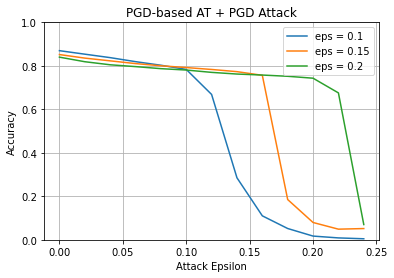

In [59]:
figure, axis = plt.subplots()

#axis.plot(eps_values, fgsm_fgsm_acc, label = "FGSM")
#axis.plot(eps_values, fgsm_pgd_acc, label = "PGD")

axis.plot(eps_values, pgd_0p1_acc, label = "eps = 0.1")
axis.plot(eps_values, pgd_0p15_acc, label = "eps = 0.15")
axis.plot(eps_values, pgd_0p2_acc, label = "eps = 0.2")

#axis.set(xlabel = "Epsilon", ylabel = "Accuracy", title = "FGSM ADVTRAIN NETA")

axis.set(xlabel = "Attack Epsilon", ylabel = "Accuracy", title = "PGD-based AT + PGD Attack")

axis.grid()
#plt.yscale("log")
plt.ylim([0, 1])
plt.legend()
plt.show()

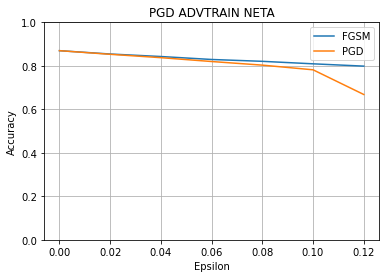

In [97]:
figure, axis = plt.subplots()

axis.plot(eps_values, pgd_fgsm_acc, label = "FGSM")
axis.plot(eps_values, pgd_pgd_acc, label = "PGD")

axis.set(xlabel = "Epsilon", ylabel = "Accuracy", title = "PGD ADVTRAIN NETA")
axis.grid()
#plt.yscale("log")
plt.ylim([0, 1])
plt.legend()
plt.show()

## Lab 3 Bonus Part (f) - Saliency Maps

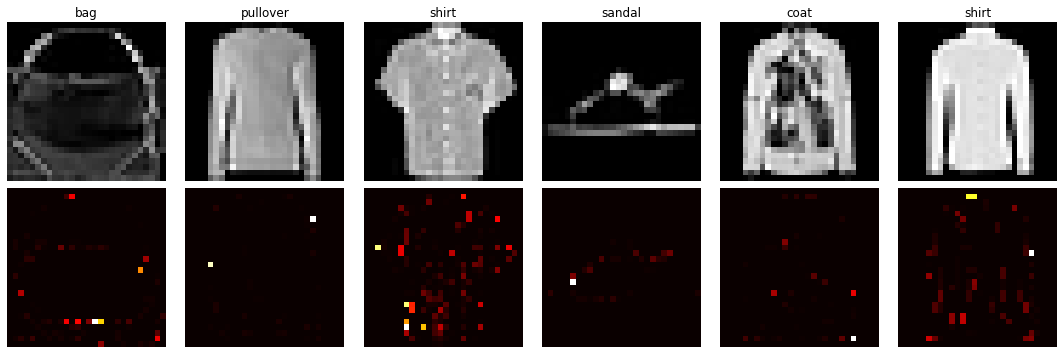

Done!


In [9]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]

whitebox = models.NetA()

#whitebox.load_state_dict(torch.load("netA_standard.pt"))   # TODO: Load your robust models
#whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p01.pt"))
#whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p05.pt"))
#whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p1.pt"))
#whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p15.pt"))
whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p2.pt"))
#whitebox.load_state_dict(torch.load("netA_advtrain_pgd0p3.pt"))

whitebox = whitebox.to(device)
whitebox.eval(); 

# test_acc,_ = test_model(whitebox,test_loader,device)
# print("Initial Accuracy of Whitebox Model: ",test_acc)

# ## Test the model against an adversarial attack

# # TODO: Set attack parameters here
# ATK_EPS = 0.1
# ATK_ITERS = 10
# ATK_ALPHA = 1.85 * (ATK_EPS / ATK_ITERS)

# whitebox_correct = 0.
# running_total = 0.

for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device) 
    labels = labels.to(device)
    
    # Reduce the batch size from 64 to 6
    # to facilitate plotting saliency maps.
    data = data[0:6]
    labels = labels[0:6]
    #print(data.shape)
    #print(labels.shape)
    
    data.requires_grad_()
    saliency_map = None
    results = whitebox.forward(data)
    results = results.gather(1, labels.view(-1, 1)).squeeze()
    results.backward(torch.FloatTensor([1., 1., 1., 1., 1., 1.]).to(device))
    saliency_map = abs(data.grad.data)
    saliency_map, _ = torch.max(saliency_map, dim = 1)
    saliency_map = saliency_map.squeeze()
    saliency_map = saliency_map.cpu().numpy()
    batch_size_six = data.shape[0]
    if batch_idx == 5 :
        plt.figure(figsize = (15, 5))
        for i in range(batch_size_six) :
            plt.subplot(2, batch_size_six, i + 1)
            plt.imshow(data[i,0].cpu().detach().numpy(), cmap = 'gray')
            plt.axis('off')
            plt.title(classes[labels[i]])
            plt.subplot(2, batch_size_six, batch_size_six + i + 1)
            plt.imshow(saliency_map[i], cmap = plt.cm.hot)
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        

#     # TODO: Perform adversarial attack here
#     adv_data = attacks.PGD_attack(whitebox, device, data.clone().detach(), labels, eps = ATK_EPS, 
#                                   alpha = ATK_ALPHA, iters = ATK_ITERS, rand_start = True)
    
#     # Sanity checking if adversarial example is "legal"
#     assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
#     assert(adv_data.max() == 1.)
#     assert(adv_data.min() == 0.)
    
#     # Compute accuracy on perturbed data
#     with torch.no_grad():
#         whitebox_outputs = whitebox(adv_data)
#         _,whitebox_preds = whitebox_outputs.max(1)
#         whitebox_correct += whitebox_preds.eq(labels).sum().item()
#         running_total += labels.size(0)
    
#     # Plot some samples
#     if batch_idx == 1:
#         plt.figure(figsize=(15,5))
#         for jj in range(12):
#             plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
#         plt.tight_layout()
#         plt.show()

# # Print final 
# whitebox_acc = whitebox_correct/running_total
# print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

print("Done!")